## IUM 4.4
Anna Lobach  
Maciej Iwański

### Definicja problemu biznesowego:
Stworzenie modułu przewidującego czy sesja użytkownika zakończy się kupnem produktu.

### Biznesowe kryterium sukcesu:
System powinien trafnie przewidywać rezultat sesji użytkownika.

### Analityczne kryterium sukcesu:
Skuteczność przewidywania na poziomie co najmniej 90%. Skuteczność wynika ze stosunku danych 89/11 (`VIEW_PRODUCT`/`BUY_PRODUCT`) - przy niższej skuteczności moglibyśmy za każdym razem określać wynik predykcji jako `VIEW_PRODUCT` i skuteczność nie spadłaby poniżej oczekiwanej.

### Definicja zadania modelowania:
Zadanie klasyfikacji - przewidywanie czy użytkownik zakończy sesję zakupem produktu. Dla każdej następnej akcji użytkownika system aktualizuje swoją predykcję dotyczącą statusu końcowego sesji.

### Analiza danych
Na początku przeprowadzona została analiza danych z wykorzystaniem biblioteki pandas.
Stwierdzliliśmy następujące nieścisłości w danych:
- Dane do uzupełnienia:
    - Uzupełnianie brakujących `user_id` - w obrębie jednej sesji może wystąpić wyłącznie jedno `user_id`
    - Uzupełnienie `product_id` w rekordach o `event_type` `BUY_PRODUCT` na podstawie poprzedzającego rekordu z `event_type` `VIEW_PRODUCT` - w sesji, która zakończyła się kupnem produktu, użytkownik musi go najpierw obejrzeć
- Dane do poprawki:
    - Produkty z niepoprawnymi cenami
- Dane do wyrzucenia:
    - Rekordy sesji o `event_type` `VIEW_PRODUCT` bez `user_id`/`product_id`
    - Rekordy sesji o `event_type` `BUY_PRODUCT` bez `user_id`/`product_id` poprzedzone `VIEW_PRODUCT` bez `user_id`/`product_id`

In [1]:
## import packages and load data
import matplotlib.pyplot as plt
import pandas as pd
import json

with open('data/sessions.jsonl') as jsonl_file:
    sessions = [ json.loads(line) for line in jsonl_file.read().splitlines() ]
with open('data/products.jsonl') as jsonl_file:
    products = [ json.loads(line) for line in jsonl_file.read().splitlines() ]
    for product in products:
        product["category"] = product["category_path"].split(";")[-1]
with open('data/users.jsonl') as jsonl_file:
    users = [ json.loads(line) for line in jsonl_file.read().splitlines() ]

In [2]:
## load data to pandas
df_sessions = pd.DataFrame(sessions)
df_products = pd.DataFrame(products)
df_users = pd.DataFrame(users)

#### Poniżej:
1. Produkty pogrupowane kategoriami. Widać wartości odbiegające od normy.
2. Liczbę produktów.

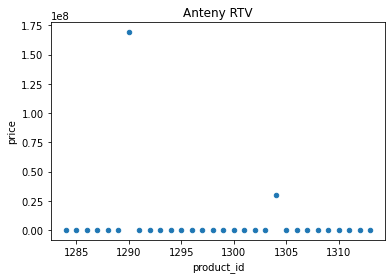

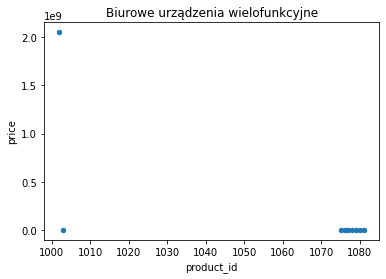

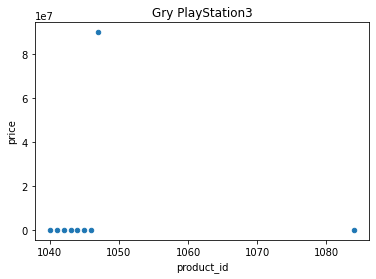

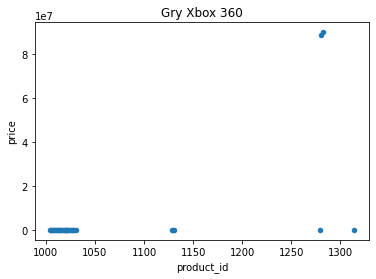

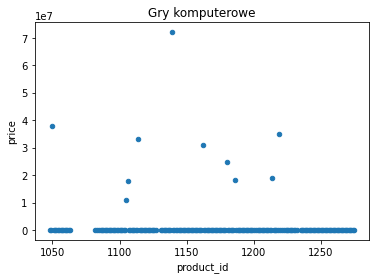

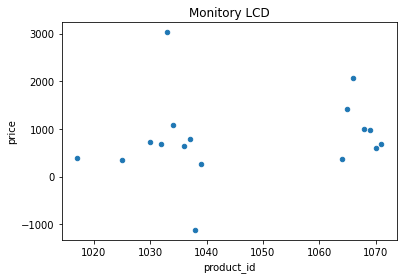

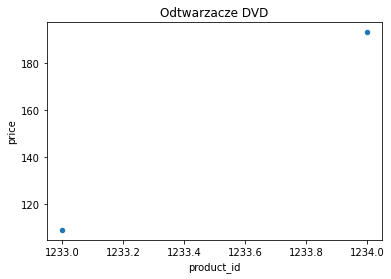

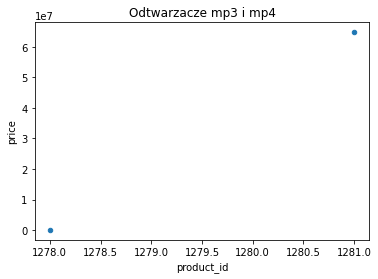

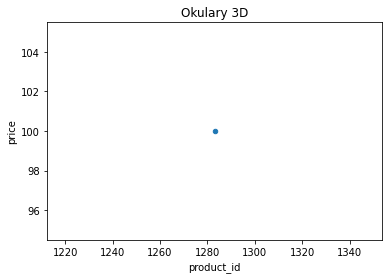

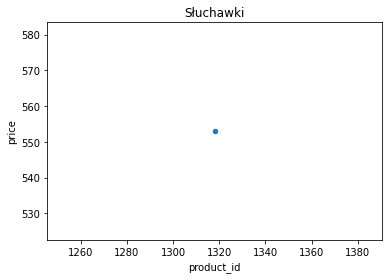

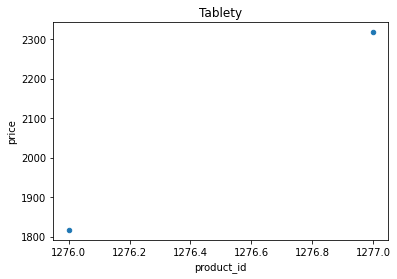

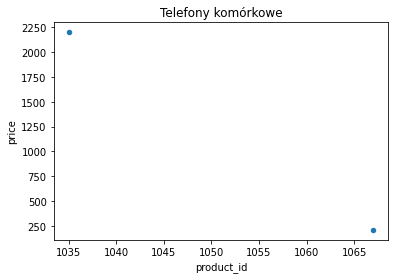

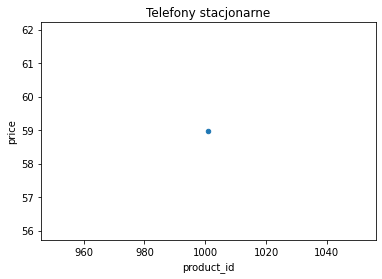

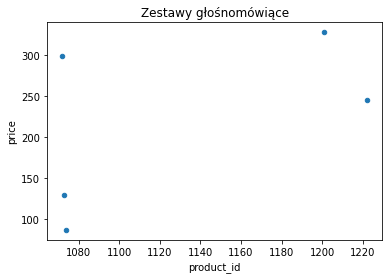

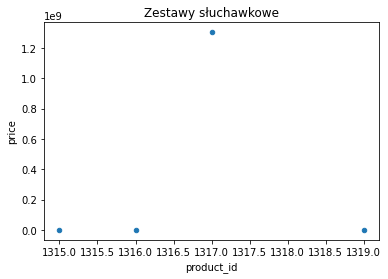

In [3]:
grouped_products = df_products.groupby("category")
for category, group in grouped_products:
  group.plot.scatter(x = "product_id", y = "price", title = category);

In [4]:
df_products.shape[0]

319

#### Poniżej:
1. Liczba użytkowników.
2. Liczba miast, z których pochodzą użytkownicy.

In [5]:
df_users.shape[0]

200

In [6]:
cities = df_users.city.unique()
len(cities)

8

#### Poniżej:
1. Procentowy podział na sesje ze względu na etykiety. 
2. Liczbę obiektów session.

In [7]:
labels = df_sessions['event_type'].value_counts(normalize = True).to_dict()
for label, percentage in labels.items():
    print("{}: {:.2f}%".format(label, percentage))

VIEW_PRODUCT: 0.89%
BUY_PRODUCT: 0.11%


In [8]:
df_sessions.shape[0]

35129

#### Kontynuacja analizy danych:
Za pomocą skryptu `data_correction.py` oczyściliśmy i połączyliśmy dane o sesjach, produktach i użytkownikach.  
Skrypt odpowiada za:
1. Uzupełnienie danych o brakujących `session_id` lub `product_id` w przypadkach, gdy informacji tej brakuje i można wywnioskować z pozostałych obiektów sesji.
1. Wyciągnięcie z danych sesji dodatkowych informacji takich jak np.
    1. godzina
    1. minuta
    1. pora dnia
    1. pora roku
    1. czas od poprzedniego logu w sekundach(gdy log jest pierwszy wartość 0)
    1. numer 
1. Po scaleniu wszystkich danych wyrzucone zostały dane z cenami ujemnymi bądź odbiegającymi od normy (produkty z cenami powyżej 10 000 były nieadekwatnego typu do ceny) - ceny te wstępnie uznane zostały jako dane do poprawki, postanowiliśmy się ich pozbyć.

Skrypt zapisuje scalone dane w pliku `merged_data_cleared.json`.
Liczba rekordów pozostałych po oczyszczeniu znajduje się poniżej:

In [9]:
with open("cleared_data/merged_data_cleared.json", "r") as json_file:
    data = json.load(
        json_file
    )
print(len(data))

29804


In [10]:
from utils import model_comparison, random_forest_check

### Feature selection

Poniżej znajduje się porównanie modeli wykorzystanych do selekcji parametrów z dosyć obszernym zestawem parametrów wejściowych. 

Do porównania został użyty RandomForestClassifier z domyślnymi ustawieniami i `random_state = 0`, a także DummyClassifier jako najprotszy model bazowy. Zestaw testowy danych jest wielkości 0.3 wszystkich danych, z `shuffle = False`. 

Do zakodowania danych kategorycznych użyta została funkcja modułu pandas `getdummies` z opcją `drop_first = True`. Funkcja ta tworzy oddzielny atrybut dla każdego wariantu danej kategorycznej. Dla X kategorii produktów otrzymujemy X atrybutów z wartościami 0 lub 1. Opcja drop first powoduje usunięcie jednego z atrybutów zgodnie z tym, że jeżeli X - 1 atrybutów określających kategorię ma wartość 0 -> oznacza to, że produkt jest kategorii X.

(na wykresach trzeba wziąć pod uwagę, że w przypadku danych kategorycznych nie obrazuje on ich istotności dla modelu)

----------------------------------------------------
Dokładność:
Random Forest Classifier : Dummy Classifier:
0.925 : 0.875
----------------------------------------------------
Feature[0]: user_id, Score: 0.06111
Feature[1]: product_id, Score: 0.07478
Feature[2]: offered_discount, Score: 0.02328
Feature[3]: hour, Score: 0.04854
Feature[4]: minute, Score: 0.07484
Feature[5]: second, Score: 0.07908
Feature[6]: month, Score: 0.03616
Feature[7]: seconds_from_last_action, Score: 0.14359
Feature[8]: number_of_actions_taken, Score: 0.17694
Feature[9]: price, Score: 0.04164
Feature[10]: day_part_evening, Score: 0.00759
Feature[11]: day_part_morning, Score: 0.00898
Feature[12]: day_part_night, Score: 0.00750
Feature[13]: year_part_fourth_quarter, Score: 0.00660
Feature[14]: year_part_second_quarter, Score: 0.00865
Feature[15]: year_part_third_quarter, Score: 0.00893
Feature[16]: category_Biurowe urządzenia wielofunkcyjne, Score: 0.00302
Feature[17]: category_Gry PlayStation3, Score: 0.00317
Fea

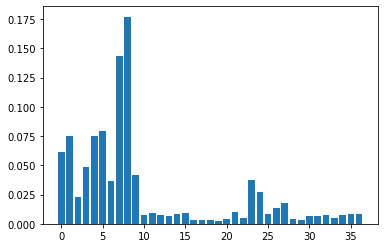

In [11]:
features = [
    "user_id",
    "product_id",
    "offered_discount",
    "hour",
    "minute",
    "second",
    "month",
    "day_part",
    "year_part",
    "seconds_from_last_action",
    "number_of_actions_taken",
    "price",
    "category",
    "city"
]

target = [
    "event_type"
]

model_comparison.feature_selection(features, target)

#### Analiza wstępnego, obszernego, zestawu atrybutów:

Jak widać, przy uruchomieniu z domyślnymi wartościami `RandomForestClassifier` i obszernym zestawem cech otrzymaliśmy wynik lepszy niż `DummyClassifier`.

Metodą backward selection postanowiliśmy ograniczać zestaw parametrów do momentu osiągnięcia minimalnego zestawu parametrów potrzebnego aby uzyskać wynik lepszy, bądź równy modelowi z zestawem startowym.

Po iteracyjnym usuwaniu `month`, `day_part`, `year_part` otrzymaliśmy wynik delikatnie lepszy niż wyjściowy:

----------------------------------------------------
Dokładność:
Random Forest Classifier : Dummy Classifier:
0.926 : 0.875
----------------------------------------------------
Feature[0]: user_id, Score: 0.07308
Feature[1]: product_id, Score: 0.09011
Feature[2]: offered_discount, Score: 0.02732
Feature[3]: hour, Score: 0.06659
Feature[4]: minute, Score: 0.08487
Feature[5]: second, Score: 0.08913
Feature[6]: seconds_from_last_action, Score: 0.15301
Feature[7]: number_of_actions_taken, Score: 0.18067
Feature[8]: price, Score: 0.04205
Feature[9]: category_Biurowe urządzenia wielofunkcyjne, Score: 0.00341
Feature[10]: category_Gry PlayStation3, Score: 0.00403
Feature[11]: category_Gry Xbox 360, Score: 0.00337
Feature[12]: category_Gry komputerowe, Score: 0.00258
Feature[13]: category_Monitory LCD, Score: 0.00310
Feature[14]: category_Odtwarzacze DVD, Score: 0.01168
Feature[15]: category_Odtwarzacze mp3 i mp4, Score: 0.00560
Feature[16]: category_Okulary 3D, Score: 0.03393
Feature[17]: cat

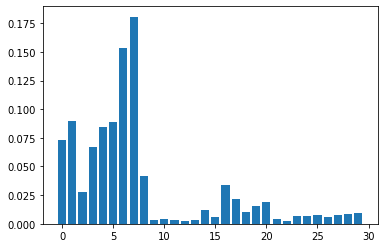

In [12]:
features = [
    "user_id",
    "product_id",
    "offered_discount",
    "hour",
    "minute",
    "second",
    "seconds_from_last_action",
    "number_of_actions_taken",
    "price",
    "category",
    "city"
]

model_comparison.feature_selection(features, target)

#### Usuwanie atrybutów numerycznych:

Patrząc na wykres postanowiliśmy usunąć jeszcze cechy numeryczne (`offered_discount` i `price`), mające najmniejszy wpływ na skuteczność modelu, zanim przeszliśmy do danych kategorycznych. 

----------------------------------------------------
Dokładność:
Random Forest Classifier : Dummy Classifier:
0.924 : 0.875
----------------------------------------------------
Feature[0]: user_id, Score: 0.08108
Feature[1]: product_id, Score: 0.09965
Feature[2]: hour, Score: 0.07447
Feature[3]: minute, Score: 0.09188
Feature[4]: second, Score: 0.09408
Feature[5]: seconds_from_last_action, Score: 0.15798
Feature[6]: number_of_actions_taken, Score: 0.18942
Feature[7]: category_Biurowe urządzenia wielofunkcyjne, Score: 0.00421
Feature[8]: category_Gry PlayStation3, Score: 0.00467
Feature[9]: category_Gry Xbox 360, Score: 0.00335
Feature[10]: category_Gry komputerowe, Score: 0.00330
Feature[11]: category_Monitory LCD, Score: 0.00350
Feature[12]: category_Odtwarzacze DVD, Score: 0.01246
Feature[13]: category_Odtwarzacze mp3 i mp4, Score: 0.00603
Feature[14]: category_Okulary 3D, Score: 0.03671
Feature[15]: category_Słuchawki, Score: 0.02646
Feature[16]: category_Tablety, Score: 0.01203
Fea

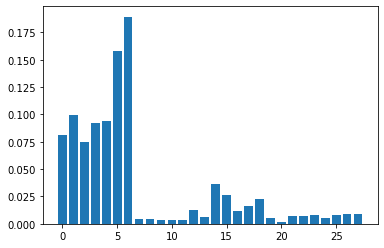

In [13]:
features = [
    "user_id",
    "product_id",
    "hour",
    "minute",
    "second",
    "seconds_from_last_action",
    "number_of_actions_taken",
    "category",
    "city"
]

model_comparison.feature_selection(features, target)

#### Dane kategoryczne:

Wynik z `random_state = 0` wskazywał na to, że model uzyskuje delikatnie mniejszą skuteczność, jednak po przeprowadzaniu kilku eksperymentów z różnymi wartościami `random_state` doszliśmy do wniosku, że dane te nie są aż tak istotne.

Po przeprowadzaniu eksperymentów i analizie danych kategorycznych wybraliśmy poniżej określone dane jako główne cechy wykorzystywane w modelu:

----------------------------------------------------
Dokładność:
Random Forest Classifier : Dummy Classifier:
0.925 : 0.875
----------------------------------------------------
Feature[0]: user_id, Score: 0.13576
Feature[1]: hour, Score: 0.10208
Feature[2]: minute, Score: 0.13312
Feature[3]: seconds_from_last_action, Score: 0.21165
Feature[4]: number_of_actions_taken, Score: 0.19128
Feature[5]: category_Biurowe urządzenia wielofunkcyjne, Score: 0.00428
Feature[6]: category_Gry PlayStation3, Score: 0.00426
Feature[7]: category_Gry Xbox 360, Score: 0.00460
Feature[8]: category_Gry komputerowe, Score: 0.00414
Feature[9]: category_Monitory LCD, Score: 0.00439
Feature[10]: category_Odtwarzacze DVD, Score: 0.01593
Feature[11]: category_Odtwarzacze mp3 i mp4, Score: 0.00873
Feature[12]: category_Okulary 3D, Score: 0.04409
Feature[13]: category_Słuchawki, Score: 0.04347
Feature[14]: category_Tablety, Score: 0.01594
Feature[15]: category_Telefony komórkowe, Score: 0.01724
Feature[16]: category_

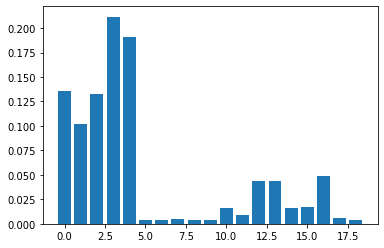

In [14]:
features = [
    "user_id",
    "hour",
    "minute",
    "seconds_from_last_action",
    "number_of_actions_taken",
    "category"
]

model_comparison.feature_selection(features, target)

#### Końcowe sprawdzenie atrybutów

Dodatkowo poniżej znajduje się kilkukrotne wywołanie `RandomForestClassifier` pokazujące średnią skuteczność w przypadku określonej przez parametr wejściowy liczby wywołań:

In [15]:
random_forest_check.random_forest_check(features, target, iterations_number = 10)

Average accuracy of 10 runs: 0.926


### Porównanie modeli

Jako punktu wyjścia postanowiliśmy użyć dwóch algorytmów:
- Random Forest Classifier:  
    Model nieliniowy, składający się z wielu drzew decyzyjnych.
- Linear Discriminant Analysis:  
    Model liniowi opisujący dane za pomocą rozkładu normalnego.

Poniżej mamy porównanie obydwu modeli, z domyślnymi wartościami Random Forest osiągał zdecydowanie lepsze wyniki.

In [16]:
model_comparison.random_lda(features, target, iterations_number = 10)

Average accurancy of 10 runs:
Random forest : Linear Discriminant Analysis:
0.925 : 0.898


### Model docelowy:
Jako model docelowy wybraliśmy `RandomForestClassifier` z biblioteki Sklearn. Atrybutami wejściowymi modelu są następujące dane (wybrane zgodnie z opisem przedstawionym powyżej):
- id użytkownika, 
- godzina, 
- minuta, 
- liczba sekund od poprzedniej akcji użytkownika, 
- liczba poprzednich akcji użytkownika,
- kategoria produktu

Wartością przewidywaną jest etykieta określająca czy według wytrenowanego modelu sesja zakończy się kupieniem czy tylko oglądaniem produktu.

### Opis aplikacji REST:

Szczegóły uruchamiania aplikacji znajdują się w `README.md` projektu.
Szczegóły korzystania z API znajdują się pod adresem `0.0.0.0:8080/docs` po uruchomieniu aplikacji. Szczególnie istotne są parametry przekazywane do żądań - założyliśmy, że klient posiada bazy lokalnie i połączy odpowiednie dane przed wysłaniem żądania. Tak więc, chociaż pole `cathegory` nie występuje w logach sesji, założyliśmy, że do wysyłania żądań i tak utworzony zostanie moduł łączący odpowiednio łączący i wysylający dane.  
Aplikacja zapisuje lokalnie w kontenerze w lokalizacji `app_data/session_data.json` słownik zbudowany z  elementami zbudowanymi w następujący sposób:
- kluczem jest `session_id` podane jako parametr żądania,
- wartością jest słownik zbudowany z:
    - listy `timestamps` poprzednich żądań danej sesji (potrzebne do wyliczania liczby akcji użytkownika i czasu w sekundach od poprzedniej akcji),
    - `last_event_type` określającego jaka była ostatnia akcja jaką wykonał użytkownik,
    - `prediction` określającego co przewidział nasz model jako rezultat końcowy sesji (predykcja nie jest wyliczana jeżeli właśnie przekazane żądanie do API posiada `BUY_PRODUCT` jako `event_type`).
    
    
W przypadku wywoływania końcówki API odpowiedzialnej za raport, zwracana jest informacja ile procentowo było poprawnych predykcji (określone na podstawie porównania `last_event_type` i `prediction`).